# 2-colour imaging: RecB-Halo + Nucleoid (Sytox)

In [27]:
from pyberries.data import DatasetPool
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

data = (DatasetPool(path='D:\DanielThedie\BACMMAN\Timelapse',
                    dsList=['240424_1', '240424_2', '240424_3', '240424_4'],
                    groups=['WT, 0', 'WT, 30 ng/mL', '$\Delta$recA, 0', '$\Delta$recA, 30 ng/mL'],
                    metadata='DateTime'
                    )
        .heatmap_metrics(object_name='Nucleoid')
        .drop_duplicates(object_name='RecB_spots', subset=['Dataset', 'Position', 'TrackHeadIndices'])
        .assign(Time_min=lambda df: df.Time_min + 15)
        .split_column(col='Group', new_cols=['Strain', 'Cipro'], delimiter=', ')
        )

Dataset 240424_1: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_2: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_3: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']
Dataset 240424_4: loaded objects ['Bacteria_large', 'RecB_spots', 'RecB_raw', 'Nucleoid']


In [29]:
data.describe(object_name='Nucleoid')

Nucleoid


,Group,nObjects,SNR,Nucleoid_size,SpineCurvilinearCoord,SpineRadialCoord,SpineLength,SpineRadius,ObjectCount,Time_min,normLongCoord,normShortCoord,centerLongCoord
Dataset,,,,,,,,,,,,,
240424_1,"WT, 0",53000,9.810525,0.914012,1.646332,0.020228,3.308712,0.894214,0.010170,35.905480,-0.002939,0.022466,-0.008024
240424_2,"WT, 30 ng/mL",83350,6.126985,1.086140,1.742064,0.008057,3.532528,0.873510,0.030966,39.203002,-0.007569,0.008862,-0.024200
240424_3,"$\Delta$recA, 0",32550,6.534020,0.963876,1.666086,0.017354,3.354322,0.895598,0.028792,39.293394,-0.005822,0.019502,-0.011075
240424_4,"$\Delta$recA, 30 ng/mL",39850,6.819260,0.953017,1.614471,0.006836,3.294269,0.906792,0.057616,46.542911,-0.012919,0.007490,-0.032664


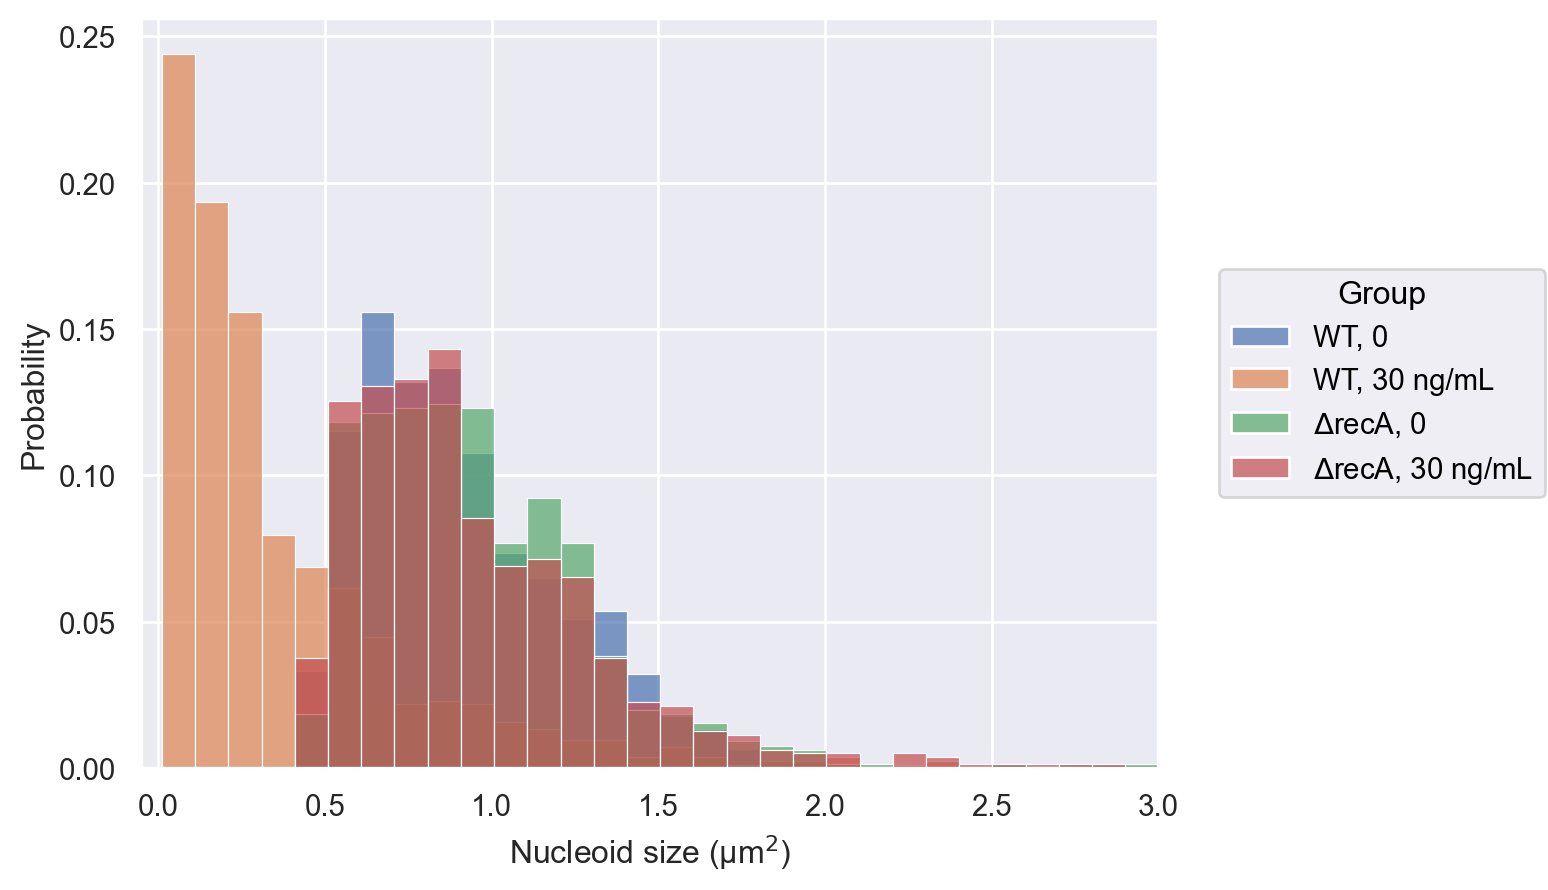

In [50]:
(
    so.Plot(data.Nucleoid, x='Nucleoid_size', color='Group')
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.1, common_norm=False))
    .limit(x=(-.05, 3))
    .label(x='Nucleoid size (µm$^2$)', y='Probability')
)

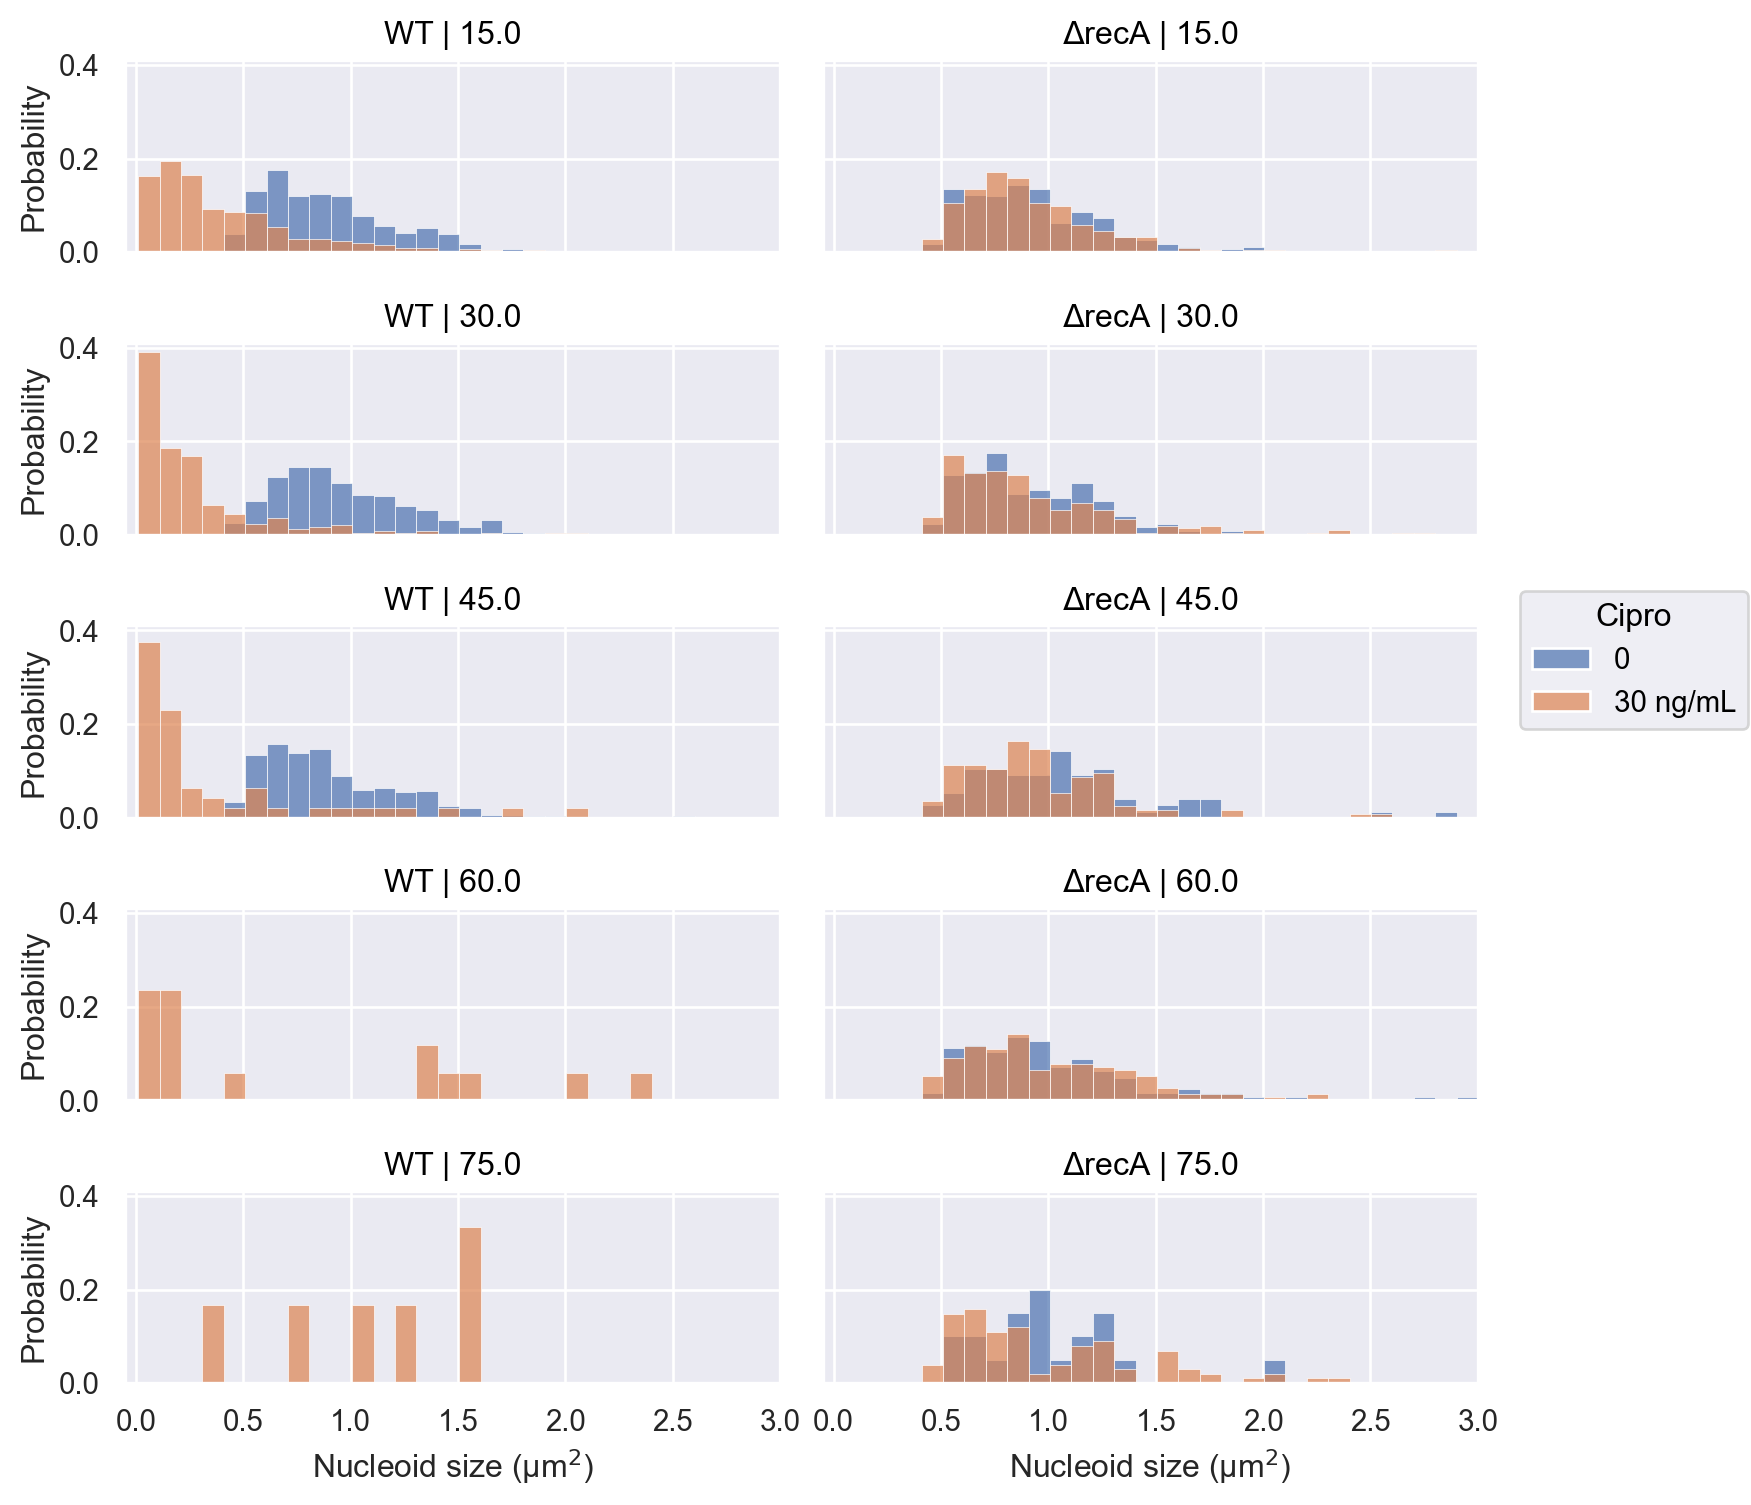

In [51]:
df = data.bin_column(object_name='Nucleoid', col='Time_min', binsize=15, binlabels='left').Nucleoid

(
    so.Plot(df, x='Nucleoid_size', color='Cipro')
    .layout(size=(8, 8))
    .facet(row='Time_min_bin', col='Strain')
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.1, common_norm=False))
    .limit(x=(-.05, 3))
    .label(x='Nucleoid size (µm$^2$)', y='Probability')
)

In [52]:
df = (data
      .Nucleoid
      .assign(Compact=lambda df: (df.Nucleoid_size < 0.5).astype('int')*100)
      .groupby('Group')
      .agg({'Compact':'mean'})
      )

display(df)

,Compact
Group,
"$\Delta$recA, 0",1.689708
"$\Delta$recA, 30 ng/mL",2.634881
"WT, 0",2.452830
"WT, 30 ng/mL",73.309179


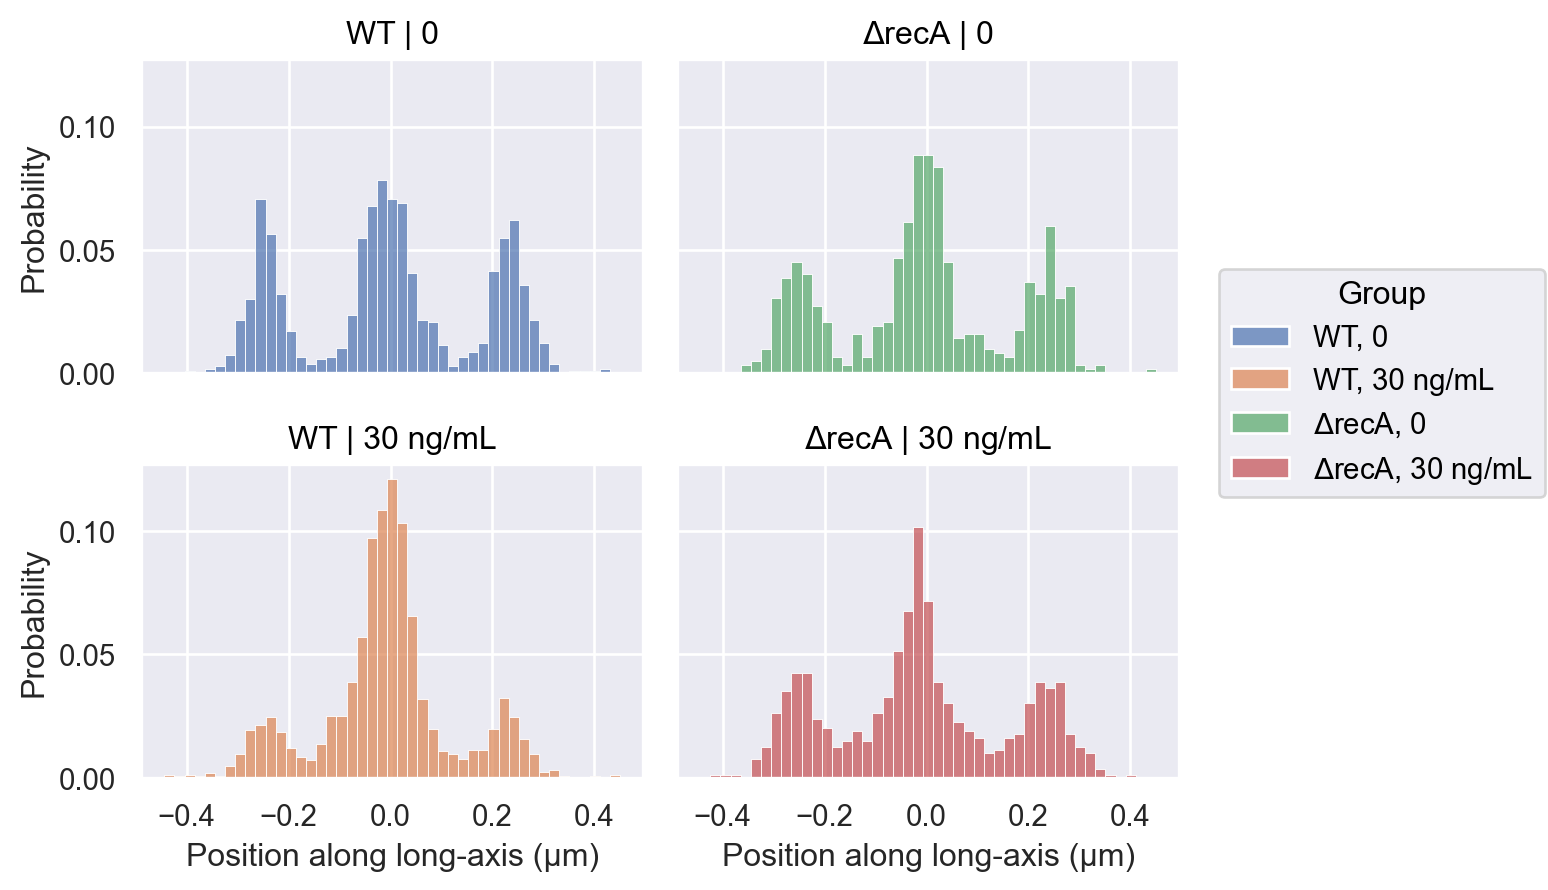

In [26]:
df = (data
      .Nucleoid
      .assign(longCell=lambda df: df.SpineLength > 2.5)
      )

(
    so.Plot(df, x='normLongCoord', color='Group')
    .facet(col='Strain', row='Cipro')
    .add(so.Bars(), so.Hist(stat='probability', binwidth=0.02, common_norm=False))
    .label(x='Position along long-axis (µm)', y='Probability')
)

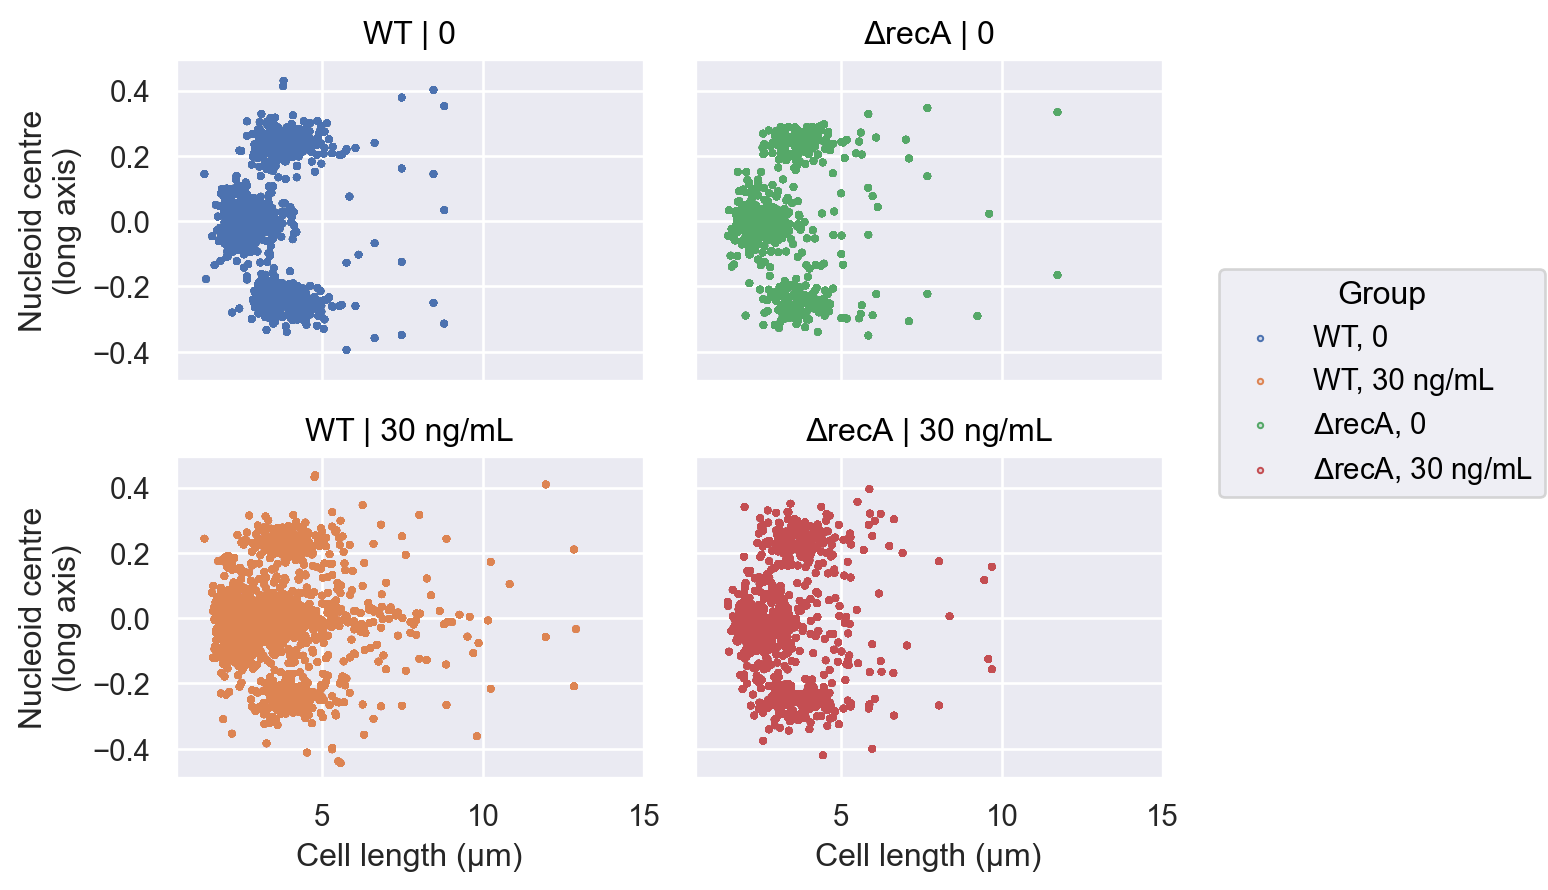

In [18]:
(
    so.Plot(data.Nucleoid, x='SpineLength', y='normLongCoord', color='Group')
    .facet(col='Strain', row='Cipro')
    .add(so.Dots(marker='.'))
    .limit(x=(None, 15))
    .label(x='Cell length (µm)', y='Nucleoid centre\n(long axis)')
)

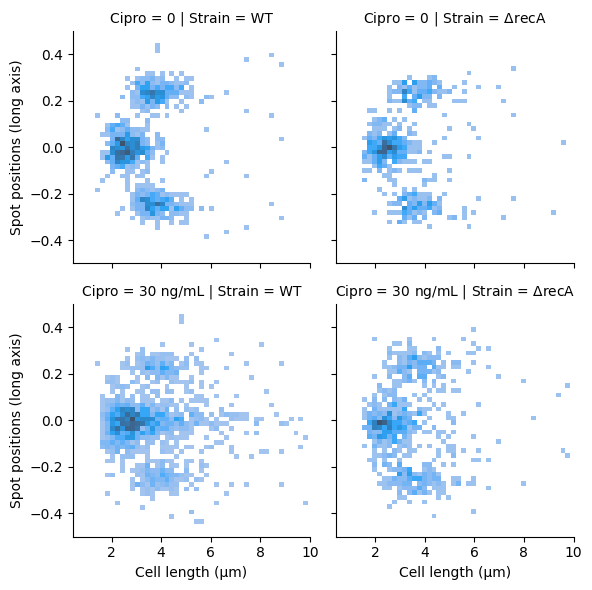

In [21]:
g = sns.FacetGrid(data.Nucleoid, col="Strain",  row="Cipro")
g.map_dataframe(sns.histplot, x='SpineLength', y='normLongCoord', binwidth=(0.2, 0.02), stat='count')
g.set(xlabel='Cell length (µm)', 
      ylabel='Spot positions (long axis)',
      xlim=(None, 10), ylim=(-.5, .5)
      )
plt.show()

In [26]:
df = (data
      .add_from_child(object_name='Bacteria_large', child='Nucleoid', col='ObjectCount', agg='sum')
      .Bacteria_large
      .assign(spots_in_nucleoid=lambda df: df.ObjectCount / df.RecBSpotCount)
      .groupby(['Group'])
      .agg({'spots_in_nucleoid':'mean'})
      )

display(df)

,spots_in_nucleoid
Group,
"$\Delta$recA, 0",0.260226
"$\Delta$recA, 30 ng/mL",0.247469
"WT, 0",0.261111
"WT, 30 ng/mL",0.271234


In [32]:
df = (data
      .get_parent_indices(object_name='RecB_spots')
      .RecB_spots
      .assign(spot_in_nucleoid=lambda df: df.ParentNucleoidIndices.isna().astype('int'),
              long_spot=lambda df: df.TrackLength.ge(5).replace({True:'Long', False:'Short'})
              )
      .groupby(['Group', 'long_spot'])
      .agg({'spot_in_nucleoid':'mean'})
      )

display(df)

spot_in_nucleoid
Group                  long_spot                  
$\Delta$recA, 0        Long               0.395939
                       Short              0.365507
$\Delta$recA, 30 ng/mL Long               0.354892
                       Short              0.383041
WT, 0                  Long               0.348837
                       Short              0.321117
WT, 30 ng/mL           Long               0.232932
                       Short              0.321529